In [2]:
# ! pip uninstall surface_erasure_decoding
# ! pip3 install git+https://github.com/JiakaiW/surface_erasure_decoding

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [27]:
import statsmodels.stats.proportion as smp

def wilson_score_interval(x, n, confidence=0.95):
    """
    Compute the Wilson score confidence interval for a binomial proportion using statsmodels.
    
    Parameters:
    x : int
        Number of successes (yes outcomes).
    n : int
        Number of trials.
    confidence : float
        Confidence level for the interval (e.g., 0.95 for 95% confidence).
    
    Returns:
    (lower_bound, upper_bound) : tuple of floats
        Lower and upper bounds of the confidence interval.
    """
    lower_bound, upper_bound = smp.proportion_confint(x, n, alpha=1-confidence, method='wilson')
    return lower_bound, upper_bound


In [2]:
gate_time = 200*1e-6 # ms
qbt_lifetime_array = 10 ** np.linspace(-2,0.5,15) # ms
formatted_floats = [f"{num:.2e}" for num in qbt_lifetime_array]
# print(f"qbt_lifetime_array: {formatted_floats}")

p_p_array = gate_time / qbt_lifetime_array
# print(f"p_p_array: {p_p_array}")

# fig, axes = plt.subplots(1,2)
# axes[0].plot(qbt_lifetime_array,p_p_array,marker = 'o')
# axes[0].set_xscale('log')
# axes[0].set_yscale('log')
# axes[0].set_xlabel('qubit lifetime (ms)')
# axes[0].set_ylabel('p_p')


decay_lifetime_array = 10 ** np.linspace(-2.7,-0.7,14)# ms
formatted_floats = [f"{num:.2e}" for num in decay_lifetime_array]
# print(f"decay_lifetime_array: {formatted_floats}")

p_e_array = gate_time / decay_lifetime_array
# print(f"p_e_array: {p_e_array}")

# axes[1].plot(decay_lifetime_array,p_e_array,marker = 'o')
# axes[1].set_xscale('log')
# axes[1].set_yscale('log')
# axes[1].set_xlabel('decay lifetime (ms)')
# axes[1].set_ylabel('p_e')


# plt.tight_layout()

p_e_list = list(p_e_array)
p_z_shift_list = [0.0]
p_m_list = [0.0]
p_p_list = list(p_p_array)


In [3]:
import os
import json
import pandas as pd

json_list = []
directory = "erasure_decode_result_v2"
for filename in os.listdir(directory):
    if filename.endswith(".txt"):
        filepath = os.path.join(directory, filename)
        with open(filepath, 'r') as f:
            json_data = json.load(f)
        json_list.append(json_data)

directory = "erasure_decode_result_v2_additional_shots"
for filename in os.listdir(directory):
    if filename.endswith(".txt"):
        filepath = os.path.join(directory, filename)
        with open(filepath, 'r') as f:
            json_data = json.load(f)
        json_list.append(json_data)

df = pd.DataFrame(json_list)


In [4]:
# df.drop('job_id', axis=1, inplace=True)
agg_rules = {
    'shots': 'sum',
    'new_circ': 'sum',
}

df_grouped = df.groupby(['p_e', 'p_z_shift','p_p','p_m','d']).agg(agg_rules).reset_index()
df_grouped['p_logi_era'] = df_grouped['new_circ'] / df_grouped['shots']
# df_grouped['p_logi_normal'] = df_grouped['normal'] / df_grouped['shots']


In [5]:
import numpy as np
import pymc as pm
from IPython.display import clear_output

error_log = []

print(f"num p_e {len(p_e_list)}, num p_p {len(p_p_list)}")
distances = [3,5,7,9]

intercept_mean_array = np.full((len(p_p_list),len(p_e_list)),np.nan)
intercept_sd_array = np.full((len(p_p_list),len(p_e_list)),np.nan)
slope_mean_array = np.full((len(p_p_list),len(p_e_list)),np.nan)
slope_sd_array = np.full((len(p_p_list),len(p_e_list)),np.nan)
for p_e_idx,p_e in enumerate(p_e_list):
    for p_p_idx,p_p in enumerate(p_p_list):
        clear_output()
        print(f"doing {p_e_idx}, {p_p_idx}")
        positive_arr = []
        tot_shots_arr = []
        distances_used = []
        for d in distances:
            num_positive = df_grouped.loc[(df_grouped['d'] == d) &
                        (df_grouped['p_e'] == p_e_list[p_e_idx]) &
                        (df_grouped['p_p'] == p_p_list[p_p_idx]) &
                        (df_grouped['p_m'] == p_m_list[-1]) &
                        (df_grouped['p_z_shift'] == p_z_shift_list[0]), 'new_circ'].iloc[0]
            num_shots = df_grouped.loc[(df_grouped['d'] == d) &
                        (df_grouped['p_e'] == p_e_list[p_e_idx]) &
                        (df_grouped['p_p'] == p_p_list[p_p_idx]) &
                        (df_grouped['p_m'] == p_m_list[-1]) &
                        (df_grouped['p_z_shift'] == p_z_shift_list[0]), 'shots'].iloc[0]
            if num_positive > 0 :
                positive_arr.append(num_positive)
                tot_shots_arr.append(num_shots)
                distances_used.append(d)
                
        if len(distances_used)>=2:
            try:
                positive_arr = np.array(positive_arr)
                tot_shots_arr = np.array(tot_shots_arr)
                distances_used = np.array(distances_used)

                y = positive_arr / tot_shots_arr

                with pm.Model() as model:
                    # Weakly informative priors for the coefficients
                    beta_0 = pm.Normal('beta_0', mu=0, sigma=10)
                    beta_1 = pm.Normal('beta_1', mu=0, sigma=10)
                    
                    # Linear predictor
                    eta = beta_0 + beta_1 * distances_used
                    
                    # Transform the linear predictor to the probability scale
                    p = pm.Deterministic('p', pm.math.exp(eta))
                    
                    # Likelihood (sampling distribution) of the observations
                    y_obs = pm.Binomial('y_obs', n=tot_shots_arr, p=p, observed=positive_arr)
                    
                    # Sampling from the posterior
                    trace = pm.sample(2000, return_inferencedata=True, tune=1000)

                intercept_mean_array[p_p_idx,p_e_idx] = trace.posterior.beta_0.mean() 
                intercept_sd_array[p_p_idx,p_e_idx] = trace.posterior.beta_0.std() 
                slope_mean_array[p_p_idx,p_e_idx] = trace.posterior.beta_1.mean() 
                slope_sd_array[p_p_idx,p_e_idx] = trace.posterior.beta_1.std() 
            except Exception as e:
                print(f"Error during sampling for p_e_idx={p_e_idx}, p_p_idx={p_p_idx}: {e}")
                error_log.append((p_e_idx, p_p_idx, f"SamplingError {str(e)}"))
                continue

doing 13, 14


In [17]:
import pickle

with open('my_tuple.pkl', 'wb') as file:
    pickle.dump((intercept_mean_array, intercept_sd_array, slope_mean_array, slope_sd_array), file)

In [ ]:
def plot_fit(p_e_idx, p_p_idx,ax,color):
    p_e = p_e_list[p_e_idx]
    p_p = p_p_list[p_p_idx]
    print(f"p_e:{p_e}, p_p:{p_p}")

    positive_arr = []
    tot_shots_arr = []
    distances_used = []
    for d in distances:
        num_positive = df_grouped.loc[(df_grouped['d'] == d) &
                    (df_grouped['p_e'] == p_e_list[p_e_idx]) &
                    (df_grouped['p_p'] == p_p_list[p_p_idx]) &
                    (df_grouped['p_m'] == p_m_list[-1]) &
                    (df_grouped['p_z_shift'] == p_z_shift_list[0]), 'new_circ'].iloc[0]
        num_shots = df_grouped.loc[(df_grouped['d'] == d) &
                    (df_grouped['p_e'] == p_e_list[p_e_idx]) &
                    (df_grouped['p_p'] == p_p_list[p_p_idx]) &
                    (df_grouped['p_m'] == p_m_list[-1]) &
                    (df_grouped['p_z_shift'] == p_z_shift_list[0]), 'shots'].iloc[0]
        positive_arr.append(num_positive)
        tot_shots_arr.append(num_shots)
        distances_used.append(d)
        
    positive_arr = np.array(positive_arr)
    tot_shots_arr = np.array(tot_shots_arr)
    distances_used = np.array(distances_used)
    y = positive_arr / tot_shots_arr

    with pm.Model() as model:
        # Weakly informative priors for the coefficients
        beta_0 = pm.Normal('beta_0', mu=0, sigma=10)
        beta_1 = pm.Normal('beta_1', mu=0, sigma=10)
        
        # Linear predictor
        eta = beta_0 + beta_1 * distances_used
        
        # Transform the linear predictor to the probability scale
        p = pm.Deterministic('p', pm.math.exp(eta))
        
        # Likelihood (sampling distribution) of the observations
        y_obs = pm.Binomial('y_obs', n=tot_shots_arr, p=p, observed=positive_arr)
        
        # Sampling from the posterior
        trace = pm.sample(2000, return_inferencedata=True, tune=1000)

    mean_intercept = trace.posterior.beta_0.mean() 
    sd_intercept = trace.posterior.beta_0.std() 
    mean_slope = trace.posterior.beta_1.mean() 
    sd_slope = trace.posterior.beta_1.std() 


    x_values = distances_used
    y_pred_mean = float(mean_intercept) + float(mean_slope) * x_values

    ax.scatter(x_values, np.log(y), label="Observed Data",color=color)
    ax.plot(x_values, y_pred_mean, label="Fitted Line", color=color)

    ax.fill_between(x_values, 
                    float(mean_intercept - sd_intercept) + float(mean_slope - sd_slope) * x_values,
                    float(mean_intercept + sd_intercept) + float(mean_slope + sd_slope) * x_values,
                    color=color, alpha=0.3, label="Uncertainty")


p_e:0.049355742297809514, p_p:0.00032757874139081276


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.


p_e:0.017052938524317534, p_p:0.00032757874139081276


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 3 seconds.
/tmp/ipykernel_10036/2043606006.py:55: RuntimeWarning: divide by zero encountered in log
  ax.scatter(x_values, np.log(y), label="Observed Data",color=color)


p_e:0.008396666781944982, p_p:0.00032757874139081276


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 3 seconds.
/tmp/ipykernel_10036/2043606006.py:55: RuntimeWarning: divide by zero encountered in log
  ax.scatter(x_values, np.log(y), label="Observed Data",color=color)


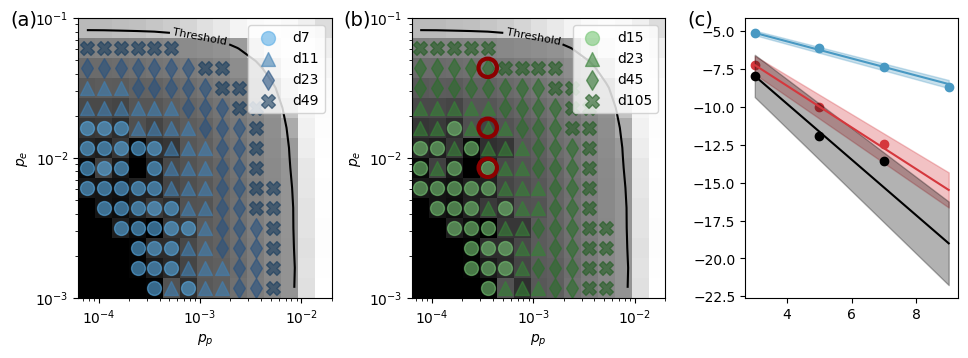

In [208]:
def get_p_log_at_distance(d,p_e_idx, p_p_idx):
    assert p_e_idx < len(p_e_list)
    assert p_p_idx < len(p_p_list)

    return np.exp(slope_mean_array[p_p_idx,p_e_idx]*d + intercept_mean_array[p_p_idx,p_e_idx])

for d in list(range(3,200))[::2]:
    temp  = []
    for i,p_e in enumerate(p_e_list):
        temp.append([])
        for j,p_p in enumerate(p_p_list):
            temp[-1].append(get_p_log_at_distance(d,i, j))
    temp = np.array(temp)
    globals()[f"p_log_d{d}_array"] = temp
    
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np

# Assuming p_p_list, p_e_list, slope_array, p_log_dX_array are predefined
colors = [value for (key,value) in  mcolors.TABLEAU_COLORS.items()]
# colors_list = [['#1b9e77', '#d95f02', '#e7298a',  '#e6ab02', '#a6761d', '#666666'],
#                ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#ffff33', '#a65628', '#f781bf', '#999999']]

colors_list = [
    [(0.353, 0.678, 0.901),(0.255, 0.502, 0.701),(0.157, 0.322, 0.502),(0.086, 0.231, 0.365),(0.063, 0.184, 0.325),(0.039, 0.137, 0.286)],
    [(0.467, 0.775, 0.459), (0.216, 0.51, 0.216),(0.169, 0.435, 0.169), (0.133, 0.365, 0.133)]
]
markers = ['o','^',"d","X"]
fig = plt.figure(figsize=(10, 3.5)) 
gs0 = fig.add_gridspec(nrows=1, ncols=1,left=0+0.07, right=1/3-0.01,bottom=0.15,top = 0.95)
gs1 = fig.add_gridspec(nrows=1, ncols=1,left=1/3+0.07, right=2/3-0.01,bottom=0.15,top = 0.95)
gs2 = fig.add_gridspec(nrows=1, ncols=1,left=2/3+0.07, right=3/3-0.05,bottom=0.15,top = 0.95)
ax0 = fig.add_subplot(gs0[0])
ax1 = fig.add_subplot(gs1[0])
ax2 = fig.add_subplot(gs2[0])

# fig,axs = plt.subplots(2,2,figsize=(5,5))
# ax0=axs[0,0]
# ax1=axs[0,1]
# ax2=axs[1,0]



temp_x = np.arange(len(p_p_list))
temp_y = np.arange(len(p_e_list))
X, Y = np.meshgrid(temp_x, temp_y)

for ax_idx, (ax, level,logical_error_str,d_list) in enumerate(zip([ ax0,ax1],
                     [1e-6,1e-12],
                     ['MegaQuop','TeraQuop'],
                     [[7,  11,  23, 49],
                      [ 15,23, 45,105]],
                     )):

    drawn_mask = np.zeros_like(X, dtype=bool)
    for d, color,marker in zip(d_list,
                        colors_list[ax_idx],
                        markers):
        
        current_mask = np.array(globals()[f"p_log_d{d}_array"] <= level, dtype=bool) & ~drawn_mask
        drawn_mask = drawn_mask | current_mask
        ax.scatter(X[current_mask], Y[current_mask], marker=marker, color=color, s=100, label=f'd{d}',alpha=0.6)

    ax.set_xticks(np.arange(len(p_p_list)))
    ax.set_yticks(np.arange(len(p_e_list)))




    contour = ax.contour(X, Y, slope_mean_array.T, levels=[0], colors='black')
    ax.clabel(contour,  fmt={0: 'Threshold'},inline=True, fontsize=8, manual=[(8, 4)])

    cmap = plt.get_cmap('Greys')
    cmap = cmap.reversed()
    cmap = cmap(np.arange(cmap.N))
    cmap[:, -1] = np.linspace(1, 1, cmap.shape[0])  # Set alpha to 1 for all colors
    cmap = mcolors.ListedColormap(cmap)
    cmap.set_bad(color='black')  # Set color for NaN values

    cax = ax.imshow(slope_mean_array.T, cmap= cmap, norm= mcolors.TwoSlopeNorm(vmin = np.nanmin(slope_mean_array.T),vcenter = 0,vmax = np.nanmax(slope_mean_array.T)),
            aspect='auto',origin='lower')

    xmin = p_p_list[-1]
    xmax = p_p_list[0]
    ymin = p_e_list[-1]-3e-6 #p_e_list[-1] == p_e_list[-1]
    ymax = p_e_list[0]
    ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
    # Create a new axis on top of the original one
    pos = ax.get_position()
    ax_twin = fig.add_axes(pos, frameon=False)
    ax_twin.set_xlim(xmin, xmax)
    ax_twin.set_ylim(ymin, ymax)
    ax_twin.set_xscale('log')
    ax_twin.set_yscale('log')
    ax_twin.set_xlabel(r'$p_p$')
    ax_twin.set_ylabel(r'$p_e$')
    ax.invert_xaxis()
    ax.invert_yaxis()
    ax.legend()


# list_of_fitting_examples = [(2,8),(5,8),(8,8)]

list_of_fitting_examples = [(2,10),(5,10),(7,10)]
for (p_e_idx,p_p_idx),color in zip(list_of_fitting_examples,
                           ['#4999c3','#d5373d','black']):
    ax1.scatter( [p_p_idx], [p_e_idx],marker='o',facecolors='none',  edgecolors='darkred', s=175,linewidths=3)
    plot_fit(p_e_idx =p_e_idx, p_p_idx= p_p_idx,ax=ax2,color=color)  



ax0.text(-0.27, 1.03, '(a)', transform=ax0.transAxes, fontsize=14,  va='top')
ax1.text(-0.27, 1.03, '(b)', transform=ax1.transAxes, fontsize=14,  va='top')
ax2.text(-0.27, 1.03, '(c)', transform=ax2.transAxes, fontsize=14,  va='top')

# plt.tight_layout()
fig.savefig('new_tolerance_scatter_plot.pdf')
